In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install lingpy
#import lingpy
#from lingpy import ipa2tokens
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
dat = pd.read_csv('data/ielexData.csv')

In [4]:
dat

,Unnamed: 0,Language,Meaning,Phonological Form,cc,ASJP
0,11,Greek,few,ˈliʝi,few:I,liSi
1,63,Bulgarian,few,ˈmaɫku,few:H,maLku
2,65,Russian,few,'maɫɔ,few:H,maLo
3,66,Polish,few,ˈmawɔ,few:H,mawo
4,68,Ukrainian,few,ˈmaɫɔ,few:H,maLo
...,...,...,...,...,...,...
4479,124,French,head,tɛt,head:D,tEt
4480,135,Italian,head,'tɛsta,head:D,tEsta
4481,136,Romanian,head,kap,head:B,kap
4482,143,Breton,head,ˈpɛnː,head:E,pEn


In [5]:
dat[dat['Meaning'] == 'few']

,Unnamed: 0,Language,Meaning,Phonological Form,cc,ASJP
0,11,Greek,few,ˈliʝi,few:I,liSi
1,63,Bulgarian,few,ˈmaɫku,few:H,maLku
2,65,Russian,few,'maɫɔ,few:H,maLo
3,66,Polish,few,ˈmawɔ,few:H,mawo
4,68,Ukrainian,few,ˈmaɫɔ,few:H,maLo
5,70,Czech,few,ˈmaːlɔ,few:H,malo
6,79,Icelandic,few,ˈfauːɪr,few:F,fauir
7,84,Swedish,few,foː,few:F,fo
8,89,Danish,few,fɔˀ,few:F,fo
9,93,English,few,fju:,few:F,fyu


In [6]:
concepts = [re.sub(':.*', '', x) for x in dat['cc']]
dat['concepts'] = concepts
uniqueconcepts = np.unique(concepts)
cognates = [list(re.sub('^.*:', '', x))[0] for x in dat['cc']]
dat['cognate_char'] = cognates

In [7]:
source_words = []
target_words = []
label = []
for concept in uniqueconcepts:
  tmp_df = dat[dat['concepts'] == concept]
  for word_idx in range(len(tmp_df)):
    source_word = tmp_df['ASJP'].iloc[word_idx]
    source_class = tmp_df['cognate_char'].iloc[word_idx]
    if len(list(source_word)) < 11:
      for word_idx2 in range(len(tmp_df)):
        if word_idx != word_idx2:
          target_word = tmp_df['ASJP'].iloc[word_idx2]
          target_class = tmp_df['cognate_char'].iloc[word_idx2]
          if len(list(target_word)) < 11:
            if source_class == target_class:
              label.append(1)
            else:
              label.append(0)
            source_words.append(source_word)
            target_words.append(target_word)


In [8]:
source_words[0]

'exo'

In [9]:
charlens = []
unique_characters = []
for i in source_words:
  charlens.append(len(list(i)))
  for j in list(i):
    unique_characters.append(j)
unique_characters = ['PAD'] + np.unique(unique_characters).tolist()

In [10]:
maxlen = max(charlens)

In [11]:
source_words_tokens = []
target_words_tokens = []
for j in range(len(source_words)):
  source_tmp = [unique_characters.index(i) for i in list(source_words[j])]
  target_tmp = [unique_characters.index(i) for i in list(target_words[j])]
  source_tmp = source_tmp + [0 for x in range(maxlen-len(source_tmp))]
  target_tmp = target_tmp + [0 for x in range(maxlen-len(target_tmp))]

  source_words_tokens.append(source_tmp)
  target_words_tokens.append(target_tmp)

In [12]:
source_words_tokens[0], target_words_tokens[0]

([15, 33, 25, 0, 0, 0, 0, 0, 0, 0], [25, 23, 19, 0, 0, 0, 0, 0, 0, 0])

In [13]:
unique_characters[25]

'o'

In [14]:
#indices = np.arange(len(source_words_tokens))
#np.random.shuffle(indices)
#split_index = int(0.9 * len(indices))
#train_indices = indices[:split_index]
#test_indices = indices[split_index:]

In [15]:
#source_words_tokens_train = source_words_tokens[train_indices]
#source_words_tokens_test = source_words_tokens[test_indices]
#target_words_tokens_train = target_words_tokens[train_indices]
#target_words_tokens_test = target_words_tokens[test_indices]
#label_train = label[train_indices]
#label_test = label[test_indices]

In [16]:
from sklearn.model_selection import train_test_split
source_train, source_test, target_train, target_test, label_train, label_test = train_test_split(source_words_tokens, target_words_tokens, label, test_size=0.1, shuffle=True, random_state=42)

In [17]:
source_train_tensor = torch.tensor(source_train, dtype=torch.long, device=device)
source_test_tensor = torch.tensor(source_test, dtype=torch.long, device=device)
target_train_tensor = torch.tensor(target_train, dtype=torch.long, device=device)
target_test_tensor = torch.tensor(target_test, dtype=torch.long, device=device)
label_train_tensor = torch.tensor(label_train, dtype=torch.int, device=device)
label_test_tensor = torch.tensor(label_test, dtype=torch.int, device=device)

In [18]:
train_dataset = TensorDataset(source_train_tensor, target_train_tensor, label_train_tensor)
test_dataset = TensorDataset(source_test_tensor, target_test_tensor, label_test_tensor)

In [19]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size = batch_size, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(test_dataset, batch_size = batch_size, generator=torch.Generator(device='cuda'))

Next step: NN that takes in both words, converts them to embeddings and predicts whether they are cognates (yes/no) = (1/0), sigmoid classification

In [20]:
class SiameseNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128, dropout = .2):
        super(SiameseNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.lin1 = nn.Linear(hidden_dim, 64)
        self.lin2 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    #def forward_once(self, x):
    #    x = self.embedding(x)
    #    _, (hidden, _) = self.lstm(x)
    #    return hidden[-1]

    def forward(self, input1, input2):
        output1_emb = self.embedding(input1)
        output2_emb = self.embedding(input2)
        out_state1, (hidden1, _) = self.lstm(output1_emb)
        out_state2, (hidden2, _) = self.lstm(output2_emb)
        output1 = hidden1[-1]
        output2 = hidden2[-1]
        diff = torch.abs(output1 - output2)
        out = self.dropout(self.relu(self.lin1(diff)))
        out = self.lin2(out)
        return out


In [21]:
vocab_size = len(unique_characters)

model = SiameseNet(vocab_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\lsm0147\Documents\Cognates\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [22]:
tan = nn.Tanh()
sigmoid = nn.Sigmoid()
mydatavalue = 3
torch.tensor([mydatavalue, mydatavalue]) * sigmoid(torch.tensor([-10, 10]))

tensor([1.3619e-04, 2.9999e+00], device='cuda:0')

In [23]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    for source_batch, target_batch, labels in train_loader:
        optimizer.zero_grad()

        source_batch = source_batch.to(device)
        target_batch = target_batch.to(device)
        labels = labels.to(device)

        outputs = model(source_batch, target_batch).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    outputs = model(source_batch, target_batch).squeeze()
    predicted = (outputs > 0.5).int()
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)

    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for source_batch, target_batch, labels in test_loader:
            source_batch = source_batch.to(device)
            target_batch = target_batch.to(device)
            labels = labels.to(device)
            
            outputs = model(source_batch, target_batch).squeeze()
            predicted = (outputs > 0.5).int()
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {100 * correct_train / total_train:.2f}%, Test Accuracy: {100 * correct_test / total_test:.2f}%")

Epoch 1/2, Loss: 0.5311, Train Accuracy: 65.60%, Test Accuracy: 68.79%
Epoch 2/2, Loss: 0.3997, Train Accuracy: 85.32%, Test Accuracy: 84.52%


In [24]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for source_batch, target_batch, labels in test_loader:
        source_batch = source_batch.to(device)
        target_batch = target_batch.to(device)
        labels = labels.to(device)
        
        outputs = model(source_batch, target_batch).squeeze()
        predicted = (outputs > 0.5).int()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 84.52%


In [25]:
def predict_cognate(word1, word2):
    def encode(word):
        encoded = [unique_characters.index(c)+1 for c in word]
        return encoded + [0] * (maxlen - len(encoded))

    model.eval()
    w1 = torch.tensor([encode(word1)], dtype=torch.long, device=device)
    w2 = torch.tensor([encode(word2)], dtype=torch.long, device=device)
    with torch.no_grad():
        output = model(w1, w2)
    return "Yes" if output.item() > 0.5 else "No"

In [26]:
predict_cognate("maLo", "fauir")

'No'

In [27]:
predict_cognate("maLo", "mawo")

'No'

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SimpleCognateDataset(Dataset):
    def __init__(self, data, unique_characters, maxlen):
        self.data = data
        self.char_to_idx = {char: i+1 for i, char in enumerate(unique_characters)}
        self.maxlen = maxlen

    def encode_word(self, word):
        #This is way faster than the "proper method"
        #Because all the data on the cpu device, so making a tensor would send it to the gpu, then pull it from the gpu, then send it again
        #Maybe if we could make this dataset once and put it on the gpu once, then it would be way faster
        encoded = [self.char_to_idx.get(c, 0) for c in word]
        return encoded + [0] * (self.maxlen - len(encoded))
    
        #encoded = [self.char_to_idx.get(c, 0) for c in word]
        #return nn.functional.pad(torch.tensor(encoded, dtype=torch.long), (0, self.maxlen - len(encoded)), value=0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        word1, word2, label = self.data[idx]
        return (
            torch.tensor(self.encode_word(word1), dtype=torch.long, device=device),
            torch.tensor(self.encode_word(word2), dtype=torch.long, device=device),
            torch.tensor(label, dtype=torch.float, device=device)
        )

class SimplePairNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super(SimplePairNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def encode_word(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return hidden[-1]

    def forward(self, input1, input2):
        enc1 = self.encode_word(input1)
        enc2 = self.encode_word(input2)
        combined = torch.cat([enc1, enc2], dim=1)
        return self.fc(combined)

In [29]:
import pandas as pd

df = pd.read_csv("data/ielexData.csv")
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

pairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        pairs.append((word1, word2, label))

df

,meaning,word,cognate_class
0,few,ˈliʝi,few:I
1,few,ˈmaɫku,few:H
2,few,'maɫɔ,few:H
3,few,ˈmawɔ,few:H
4,few,ˈmaɫɔ,few:H
...,...,...,...
4479,head,tɛt,head:D
4480,head,'tɛsta,head:D
4481,head,kap,head:B
4482,head,ˈpɛnː,head:E


In [30]:
pairs

[('e̞ˈɣo̞', "'ɑmi:", 1),
 ('e̞ˈɣo̞', 'mɛ̃', 1),
 ('e̞ˈɣo̞', 'as', 1),
 ('e̞ˈɣo̞', 'ja', 1),
 ('e̞ˈɣo̞', 'ja', 1),
 ('e̞ˈɣo̞', 'ja', 1),
 ('e̞ˈɣo̞', 'jaː', 1),
 ('e̞ˈɣo̞', 'ɐʃ', 1),
 ('e̞ˈɣo̞', 'jɛɣ', 1),
 ('e̞ˈɣo̞', 'jɑːɡ, jɑː', 1),
 ('e̞ˈɣo̞', 'jɑj', 1),
 ('e̞ˈɣo̞', 'aɪ', 1),
 ('e̞ˈɣo̞', 'ɪk', 1),
 ('e̞ˈɣo̞', 'ɪç', 1),
 ('e̞ˈɣo̞', 'ʒɔ, jɔ', 1),
 ('e̞ˈɣo̞', 'eu', 1),
 ('e̞ˈɣo̞', 'ʝo', 1),
 ('e̞ˈɣo̞', 'ʒə', 1),
 ('e̞ˈɣo̞', "'io", 1),
 ('e̞ˈɣo̞', 'jew, jo', 1),
 ('e̞ˈɣo̞', 'ˈmeː', 0),
 ('e̞ˈɣo̞', 'miː, viː', 0),
 ('e̞ˈɣo̞', 'mʲeː', 0),
 ("'ɑmi:", 'mɛ̃', 1),
 ("'ɑmi:", 'as', 1),
 ("'ɑmi:", 'ja', 1),
 ("'ɑmi:", 'ja', 1),
 ("'ɑmi:", 'ja', 1),
 ("'ɑmi:", 'jaː', 1),
 ("'ɑmi:", 'ɐʃ', 1),
 ("'ɑmi:", 'jɛɣ', 1),
 ("'ɑmi:", 'jɑːɡ, jɑː', 1),
 ("'ɑmi:", 'jɑj', 1),
 ("'ɑmi:", 'aɪ', 1),
 ("'ɑmi:", 'ɪk', 1),
 ("'ɑmi:", 'ɪç', 1),
 ("'ɑmi:", 'ʒɔ, jɔ', 1),
 ("'ɑmi:", 'eu', 1),
 ("'ɑmi:", 'ʝo', 1),
 ("'ɑmi:", 'ʒə', 1),
 ("'ɑmi:", "'io", 1),
 ("'ɑmi:", 'jew, jo', 1),
 ("'ɑmi:", 'ˈmeː', 0),
 ("'ɑmi:", 'miː, 

In [31]:
pairs_df = pd.DataFrame(pairs, columns=['Word1', 'Word2', 'Label'])
pairs_df

,Word1,Word2,Label
0,e̞ˈɣo̞,'ɑmi:,1
1,e̞ˈɣo̞,mɛ̃,1
2,e̞ˈɣo̞,as,1
3,e̞ˈɣo̞,ja,1
4,e̞ˈɣo̞,ja,1
...,...,...,...
47269,voj,xwi,1
47270,voj,ʃivʲ,1
47271,"ˈxwi, ˈhwi",xwi,1
47272,"ˈxwi, ˈhwi",ʃivʲ,1


In [32]:
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
import numpy as np
from tqdm import tqdm
import time

# Prepare data
all_words = [w for pair in pairs for w in pair[:2]]
all_answers = [w for pair in pairs for w in pair[2:]]
unique_characters = sorted(set("".join(all_words)))
maxlen = max(len(w) for w in all_words)

import matplotlib.pyplot as plt
def show_box_plot(data, title="Cross Validation Accuracies"):
    f = plt.figure()
    f.set_figwidth(4)
    f.set_figheight(1)

    # Create a box and whiskers plot
    plt.boxplot(data, vert=False)

    plt.scatter(data, [1]*len(data), color='blue', alpha=0.3, s=20)

    # Add title and labels
    plt.title(title)
    plt.ylabel('Values')

    # Show the plot
    plt.show()

def show_confusion_matrix(cm, title="Confusion Matrix"):
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])   
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['True Negative', 'True Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

def cv_test_model(model_maker):
    loo = StratifiedKFold(n_splits = 10)

    # Store results for each fold
    all_accuracies = []
    all_predictions = []
    all_true_labels = []

    for fold, (train_idx, test_idx) in enumerate(tqdm(loo.split(pairs_df.iloc[:, :2], pairs_df.iloc[:, 2:]), total=loo.get_n_splits(), desc="LOO-CV Progress")):
        # Split data
        train_data = [pairs[i] for i in train_idx]
        test_data = [pairs[i] for i in test_idx]
        
        # Create model for this fold
        model = model_maker()
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Create datasets and dataloaders
        train_dataset = SimpleCognateDataset(train_data, unique_characters, maxlen)
        test_dataset = SimpleCognateDataset(test_data, unique_characters, maxlen)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                                generator=torch.Generator(device='cuda'))
        test_loader = DataLoader(test_dataset, batch_size=1, 
                                generator=torch.Generator(device='cuda'))
        
        # Train model
        model.train()
        for epoch in range(500):
            total_loss = 0
            for word1, word2, label in train_loader:
                optimizer.zero_grad()
                output = model(word1, word2).squeeze()
                #print(output.get_device(), label.get_device())
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        
        # Test on the single held-out sample
        model.eval()
        with torch.no_grad():
            for word1, word2, label in test_loader:
                output = model(word1, word2).squeeze()
                predicted = (output > 0.5).int()
                
                # Store results
                all_predictions.append(predicted.item())
                all_true_labels.append(label.int().item())
                all_accuracies.append(1 if predicted.item() == label.int().item() else 0)

    # Calculate overall statistics
    overall_accuracy = np.mean(all_accuracies)
    correct_predictions = sum(all_accuracies)
    total_predictions = len(all_accuracies)

    print(f"\nCross-Validation Results:")
    print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

    fold_accuracies = [np.mean(fold) for fold in np.array_split(all_accuracies, loo.get_n_splits())]
    show_box_plot(fold_accuracies)

    # Additional metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

    precision = precision_score(all_true_labels, all_predictions, zero_division=0)
    recall = recall_score(all_true_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_true_labels, all_predictions, zero_division=0)
    cm = confusion_matrix(all_true_labels, all_predictions)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    show_confusion_matrix(cm)

In [ ]:
def simple_nn_model_maker():
    # Model parameters
    embedding_dim = 64
    hidden_dim = 128
    vocab_size = len(unique_characters)

    return SimplePairNN(vocab_size, embedding_dim, hidden_dim)

cv_test_model(simple_nn_model_maker)

LOO-CV Progress:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\lsm0147\Documents\Cognates\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
LOO-CV Progress: 100%|██████████| 10/10 [67:03:57<00:00, 24143.76s/it]  


Cross-Validation Results:
Overall Accuracy: 76.88%
Correct Predictions: 36346/47274


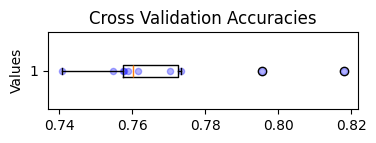

Precision: 0.639
Recall: 0.510
F1-Score: 0.567


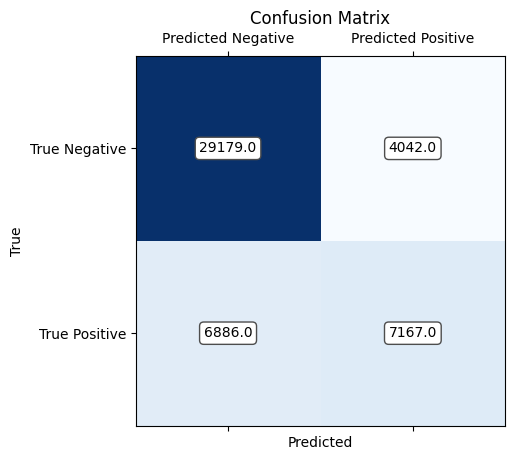

In [33]:
from transformer_stuff import TransformerCognateModel, UnbatchedWrapper

def simple_nn_model_maker():
    # Model parameters
    embedding_dim = 64
    hidden_dim = 128
    vocab_size = len(unique_characters)

    model = TransformerCognateModel(vocab_size, embedding_dim, hidden_dim)
    return model
    #return UnbatchedWrapper(model)

cv_test_model(simple_nn_model_maker)

In [ ]:
final_model = SimplePairNN(vocab_size, embedding_dim, hidden_dim)
final_criterion = nn.BCELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=0.001)

final_dataset = SimpleCognateDataset(pairs, unique_characters, maxlen)
final_loader = DataLoader(final_dataset, batch_size=32, shuffle=True, 
                         generator=torch.Generator(device='cuda'))

for epoch in tqdm(range(5), desc="Training final model"):
    final_model.train()
    total_loss = 0
    for word1, word2, label in final_loader:
        final_optimizer.zero_grad()
        output = final_model(word1, word2).squeeze()
        loss = final_criterion(output, label)
        loss.backward()
        final_optimizer.step()
        total_loss += loss.item()
    print(f"Final model - Epoch {epoch+1}/5, Loss: {total_loss / len(final_loader):.4f}")

final_model.eval()
final_predictions = []
final_true_labels = []

with torch.no_grad():
    for word1, word2, label in tqdm(final_loader, desc="Evaluating final model"):
        output = final_model(word1, word2).squeeze()
        predicted = (output > 0.5).int()
        
        # Handle both single samples and batches
        if predicted.dim() == 0:
            final_predictions.append(predicted.item())
            final_true_labels.append(label.int().item())
        else:
            final_predictions.extend(predicted.cpu().numpy())
            final_true_labels.extend(label.int().cpu().numpy())

# Calculate final model metrics
final_accuracy = np.mean(np.array(final_predictions) == np.array(final_true_labels))
final_precision = precision_score(final_true_labels, final_predictions, zero_division=0)
final_recall = recall_score(final_true_labels, final_predictions, zero_division=0)
final_f1 = f1_score(final_true_labels, final_predictions, zero_division=0)
final_cm = confusion_matrix(final_true_labels, final_predictions)

print(f"\nFinal Model Performance (on all data):")
print(f"Accuracy: {final_accuracy * 100:.2f}%")
print(f"Precision: {final_precision:.3f}")
print(f"Recall: {final_recall:.3f}")
print(f"F1-Score: {final_f1:.3f}")
print(f"Confusion Matrix:")
print(final_cm)

In [ ]:
def predict_pair(word1, word2):
    def encode(w):
        char_to_idx = {char: i+1 for i, char in enumerate(unique_characters)}
        idxs = [char_to_idx.get(c, 0) for c in w]
        return idxs + [0] * (maxlen - len(idxs))

    w1 = torch.tensor([encode(word1)], dtype=torch.long, device=device)
    w2 = torch.tensor([encode(word2)], dtype=torch.long, device=device)
    final_model.eval()
    with torch.no_grad():
        out = final_model(w1, w2)
    return "Yes" if out.item() > 0.5 else "No"

https://github.com/pytorch/examples/tree/main/word_language_model